<img src="assets/header_notebook.jpg" />

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Librairies</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

Run the following commands on terminal to install PySR:

```
python
import pysr
pysr.install(precompile = False)
```

Now you are good to go !


In [ ]:
import pysr
import numpy as     np

from   pysr        import PySRRegressor
from   matplotlib  import pyplot as plt
from   sympy       import *
from   julia       import Julia

# Installing Julia
julia = Julia(compiled_modules = False, threads = 'auto')

from julia       import Main
from julia.tools import redirect_output_streams

# Used to display correctly Julia's output
redirect_output_streams()

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>PySR - Playground</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [7]:
np.random.seed(0)

# Initialization of the fake datasets
u =  np.random.randn(1, 64, 64)
v =  np.random.randn(1, 64, 64)
q =  np.random.randn(1, 64, 64)

print(u.shape, v.shape, q.shape)

# ------- SHAPING X0 --------
# Note : 1st dimension = Values for u, v, q
#        2nd dimension = snapshot index
#        3rd dimension = input variable index
u = u.flatten('F')
v = v.flatten('F')
q = q.flatten('F')

print(u.shape, v.shape, q.shape)

u = np.expand_dims(u, axis = 1)
v = np.expand_dims(v, axis = 1)
q = np.expand_dims(q, axis = 1)

print(u.shape, v.shape, q.shape)

X0 = np.concatenate((u, v, q), axis = 1)

print(X0.shape)

X0 = np.expand_dims(X0, axis = 1)

print(X0.shape)

# ------- SHAPING X1 --------
# X1 = cos(u) + v * q^2

X1 = np.cos(X0[:, 0, 0]) + X0[:, 0, 1] * X0[:, 0, 2]**2

print(X1.shape)

X1 = np.expand_dims(X1, axis = (1, 2))

print(X1.shape)

# ------- SHAPING X2 --------
# X2 = [X0, X1]

X2 = np.concatenate((X0, X1), axis = 2)

print(X2.shape)

# ------- SHAPING X3 --------
# X3 = exp(u) + q * X1 - v**2

X3 = np.exp(X2[:, 0, 0]) - X2[:, 0, 1]**2 + X2[:, 0, 2] * X2[:, 0, 3]

print(X3.shape)

X3 = np.expand_dims(X3, axis = (1, 2))

print(X3.shape)

(1, 64, 64) (1, 64, 64) (1, 64, 64)
(4096,) (4096,) (4096,)
(4096, 1) (4096, 1) (4096, 1)
(4096, 3)
(4096, 1, 3)
(4096,)
(4096, 1, 1)
(4096, 1, 4)
(4096,)
(4096, 1, 1)


In [8]:
"""
---- Equations ----
X0 = 1st dimension = Values for u, v, q
     2nd dimension = snapshot index
     3rd dimension = input variable index
X1 = cos(u) + v * q^2
X2 = [X0, X1]
X3 = exp(u) + q * X1 - v**2
"""

# Random indexes (small sample size needed by PySR)
idx = np.random.randint(0, 4095, size = 1000)

# Initialization of the models
model_f = PySRRegressor(
    model_selection  = 'best',
    binary_operators = ["plus", "sub", "mult", "div"],
    unary_operators  = ["square", "cube", "exp", "log", "sqrt", "sin", "cos", "tanh", "erf"],
    niterations      = 2,
    procs            = 4,
    populations      = 100,
)

model_g = PySRRegressor(
    model_selection  = 'best',
    binary_operators = ["plus", "sub", "mult", "div"],
    unary_operators  = ["square", "cube", "exp", "log", "sqrt", "sin", "cos", "tanh", "erf"],
    niterations      = 2,
    procs            = 4,
    populations      = 100,
)

In [ ]:
"""
g(u, v, q, f(X0)) = exp(u) + q * X1 - v**2
"""

print(X0.shape, X1.shape)

X0_PYSR = X0.squeeze(axis = 1)
X1_PYSR = X1.squeeze(axis = 1)

print(X0_PYSR.shape, X1_PYSR.shape)

# Fitting the model (1) - Finding function f
model_f.fit(X0_PYSR[idx, :], X1_PYSR[idx, :])

In [15]:
# ---- Table of results ----
model_f

PySRRegressor.equations_ = [
	   pick      score                          equation          loss  complexity
	0         0.000000                                x1  2.345894e+00           1
	1         0.097441                 (x1 + 0.64449674)  1.930512e+00           3
	2         1.202316                 (square(x2) * x1)  5.801138e-01           4
	3         0.526906  ((square(x2) * x1) + 0.61472446)  2.022313e-01           6
	4  >>>>  29.960578     ((square(x2) * x1) + cos(x0))  1.968497e-14           7
]

In [16]:
# ---- Best equation ----
model_f.sympy()

x1*x2**2 + cos(x0)

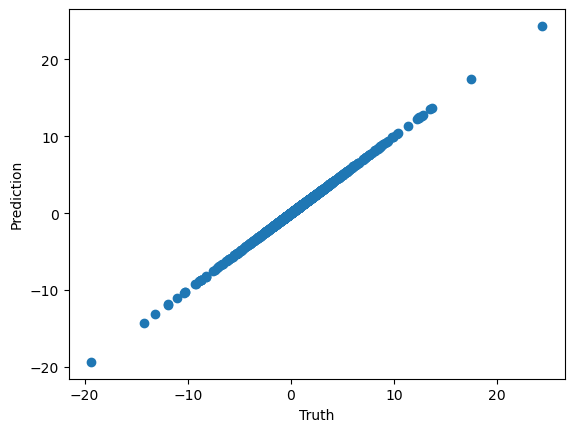

In [17]:
# ---- Plotting equation ----
from matplotlib import pyplot as plt

plt.scatter(X1_PYSR[:, :], model_f.predict(X0_PYSR[:, :]))
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

In [ ]:
"""
g(u, v, q, f(X0)) = exp(u) + q * X1 - v**2
"""

print(X2.shape, X3.shape)

X2_PYSR = X2.squeeze(axis = 1)
X3_PYSR = X3.squeeze(axis = 1)

print(X2_PYSR.shape, X3_PYSR.shape)

# Fitting the model (2) - Finding function g
model_g.fit(X2_PYSR[idx, :], X3_PYSR[idx, :])

In [19]:
# ---- Table of results ----
model_g

PySRRegressor.equations_ = [
	   pick      score                              equation          loss  \
	0         0.000000                                    x0  1.793682e+01   
	1         0.328417                               exp(x0)  1.291563e+01   
	2         0.314336                             (x2 * x3)  9.431950e+00   
	3         0.173397                      (x0 + (x2 * x3))  6.667928e+00   
	4         0.911944                 (exp(x0) + (x2 * x3))  2.678790e+00   
	5         0.206311  ((exp(x0) + (x2 * x3)) + -0.9521912)  1.773125e+00   
	6  >>>>  30.562349  (exp(x0) + ((x2 * x3) - square(x1)))  9.455401e-14   
	
	   complexity  
	0           1  
	1           2  
	2           3  
	3           5  
	4           6  
	5           8  
	6           9  
]

In [20]:
# ---- Best equation ----
model_g.sympy()

-x1**2 + x2*x3 + exp(x0)

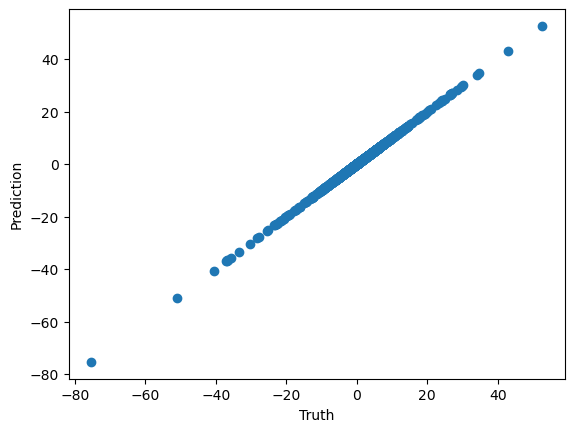

In [21]:
# ---- Plotting equation ----
from matplotlib import pyplot as plt

plt.scatter(X3_PYSR[:, :], model_g.predict(X2_PYSR[:, :]))
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Sympy - Playground & Notes</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [22]:
# Convert the model to a pytorch model ! (Can use torch tensors as inputs)
torch_model = model_f.pytorch()

In [26]:
# Convert the model to a sympy model ! (Can be used to vizualize expression after taking divergence)
sympy_model = model_f.sympy()

# Defining own coordinate system
base = x0, x1, x2 = symbols("x0 x1 x2")

# ----- Functions -------
from sympy import *

def gradient(f, coords):
  return Matrix([diff(f, c) for c in coords])

def divergence(f, coords):
  terms = [diff(f, c) for c in coords]
  return Add(*terms)

def curl(f, coords):
  return Matrix([
      diff(f, coords[1]) - diff(f, coords[2]),
      diff(f, coords[2]) - diff(f, coords[0]),
      diff(f, coords[0]) - diff(f, coords[1]) 
  ])

In [27]:
gradient(sympy_model, base)

Matrix([
[-sin(x0)],
[   x2**2],
[ 2*x1*x2]])

In [28]:
divergence(sympy_model, base)

2*x1*x2 + x2**2 - sin(x0)

In [29]:
curl(sympy_model, base)

Matrix([
[ -2*x1*x2 + x2**2],
[2*x1*x2 + sin(x0)],
[ -x2**2 - sin(x0)]])

In [30]:
# A bite more complex ! Let's find the expression of g but as a function of X0 not (X0, X1)
sp_model_f = model_f.sympy()
sp_model_g = model_g.sympy()

print("Function f           : ", sp_model_f)
print("Function g           : ", sp_model_g)

# Creation of the complete base (inputs + intermediate variables)
base = x0, x1, x2, x3 = symbols("x0 x1 x2 x3")

# Substitution
sp_model_g = sp_model_g.subs({x3 : sp_model_f})

# Final result
print("Function g (complete): \n\n")
pprint(sp_model_g, use_unicode = True)

Function f           :  x1*x2**2 + cos(x0)
Function g           :  -x1**2 + x2*x3 + exp(x0)
Function g (complete): 


    2      ⎛     2          ⎞    x₀
- x₁  + x₂⋅⎝x₁⋅x₂  + cos(x₀)⎠ + ℯ  
